In [1]:
import copy
import random
import numpy as np
from enum import Enum

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
#EASY_21
class Card:
  def __init__(self,force_black = False):
    self.value = random.randint(1,10)
    if force_black or random.randint(1,3) != 3:
      self.is_black = True
    else:
      self.is_black = False
      self.value = -self.value

class Action(Enum):
  hit = 0
  stick = 1


  def to_action(n):
      return Action.hit if n==0 else Action.stick

  def as_int(a):
      return 0 if a==Action.hit else 1

class State:
  def __init__(self, dealer, player, is_terminal = False):
    self.dealer = dealer #dealer sum
    self.player = player #player sum
    self.is_terminal = is_terminal

class Environment:
  def __init__(self):
        self.dealer_value_count = 10 # [1:10], note that black card is enforced at the start
        self.player_value_count = 21 # [1:21]
        self.action_count = 2 # hit and stick

  def check_bust(self, player_sum):
        return player_sum < 1 or player_sum > 21

  def generate_reward_bust(self, s):
      if s.player > s.dealer:
          return 1
      elif s.player == s.dealer:
          return 0
      else:
          return -1

  def dealer_turn(self, s):
        """A full implementation of the dealer turn.

           The dealer turn starts when the agent sticks and
           ends when the dealer action is busted or action = sticks.
        """
        action = None
        while not s.is_terminal and action != Action.stick:
            if s.dealer >= 17:
                action = Action.stick
            else:
                action = Action.hit
            if action == Action.hit:
                s.dealer += Card().value
            s.is_terminal = self.check_bust(s.dealer)
        return s

  def gen_start_state(self):
      s = State(Card(True).value,Card(True).value)
      return s

  def step(self, s, a):
        """
            Given a state and an action return the next state.

            Args:
                s (State): Current state.
                a (Action): Action chosen by player.
            return:
                next_s (State): Next state
                r (Integer): Reward (-1, 0, 1).
        """
        # initially there's no reward and the next_s is equal to the
        # current state
        r = 0
        next_s = copy.copy(s)

        # if the player sticks then it's dealer turn
        if a == Action.stick:
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1
            else:
                next_s.is_terminal = True
                r = self.generate_reward_bust(next_s)
        else:
            next_s.player += Card().value
            next_s.is_terminal = self.check_bust(next_s.player)

            # if end of the game then player lost: reward = -1
            if next_s.is_terminal:
                r = -1

        return next_s, r

In [12]:
#EASY_21: MONTE-CARLO CONTROL

class MC_Agent:
  def __init__(self, environment, No=200, gamma=1):
    self.env = environment
    self.No = No
    self.gamma = gamma
    self.V = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1))
    self.Q = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1, self.env.action_count))
    self.N = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1, self.env.action_count))
    self.iterations = 0
    self.wins = 0

  def get_alpha(self, state, a):
    alpha = 1/self.N[state.dealer][state.player][Action.as_int(a)]
    return alpha

  def get_e(self, state):
    e = self.No/((self.No+sum(self.N[state.dealer,state.player,:])*1.0))
    return e

  def get_max_action(self, state):
    return np.max(self.Q[state.dealer,state.player,:])

  def get_value_function(self):
    for i in range(1, self.env.dealer_value_count + 1):
        for j in range(1, self.env.player_value_count + 1):
            s = State(i, j)
            self.V[i][j] = self.get_max_action(s)
    return self.V

  def choose_random_action(self):
    return Action.hit if random.random() <= 0.5 else Action.stick

  def choose_best_action(self, state):
    return Action.hit if np.argmax(self.Q[state.dealer][state.player]) == 1 else Action.stick

  def control(self, episode):
    j = 0
    for s,a,_ in episode:
      Gt = sum([x[2]*(self.gamma**i) for i,x in enumerate(episode[j:])])
      self.N[s.dealer][s.player][Action.as_int(a)]+=1
      error = Gt - self.Q[s.dealer][s.player][Action.as_int(a)]
      self.Q[s.dealer][s.player][Action.as_int(a)] += self.get_alpha(s, a) * error
      j += 1

  def policy(self, state):
    e = self.get_e(state)
    if random.random()<=e:
      a = self.choose_random_action()
    else:
      a = self.choose_best_action(state)

    return a

  def train(self, steps):
    self.episodes = steps
    for e in range(steps):
      episode = []
      s = self.env.gen_start_state()

      while not s.is_terminal:
        a = self.policy(s)
        next_s, r = self.env.step(copy.copy(s), a)
        episode.append((s,a,r))
        s = next_s
      if e % 10000 == 0 and self.iterations > 0:
        print(self.wins, self.iterations)
        print("Episode: %d, score: %f" % (e, (float(self.wins)/(self.iterations)*100.0)))

      self.iterations += 1
      if r == 1:
          self.wins += 1

      self.control(episode)

    # return self.get_value_function()
  def plot_frame(self, ax):
    V = self.get_value_function()
    def get_stat_val(x,y):
      return V[x,y]
    X = np.arange(1,self.env.dealer_value_count+1)
    Y = np.arange(1,self.env.player_value_count+1)
    X,Y = np.meshgrid(X,Y)
    Z = get_stat_val(X,Y)

    surf = ax.plot_surface(X,Y,Z,cmap=cm.bwr,antialiased=False)
    return surf


4259 10000
Episode: 10000, score: 42.590000
7895 20000
Episode: 20000, score: 39.475000
11079 30000
Episode: 30000, score: 36.930000
13767 40000
Episode: 40000, score: 34.417500
16211 50000
Episode: 50000, score: 32.422000
18353 60000
Episode: 60000, score: 30.588333
20251 70000
Episode: 70000, score: 28.930000
21979 80000
Episode: 80000, score: 27.473750
23559 90000
Episode: 90000, score: 26.176667


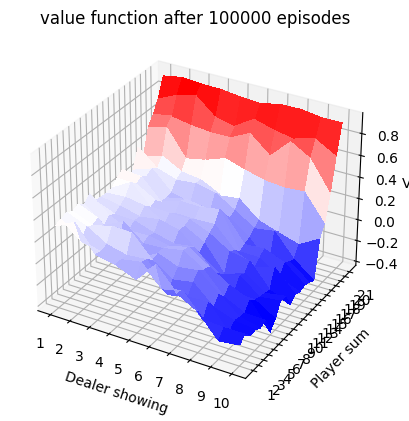

In [13]:
environment = Environment()
mc_agent = MC_Agent(environment)
mc_agent.train(100000)

fig = plt.figure()
ax = fig.add_subplot(111,projection ='3d')
mc_agent.plot_frame(ax)
plt.title('value function after %d episodes' % mc_agent.episodes)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('V(s)')
ax.set_xticks(range(1,mc_agent.env.dealer_value_count+1))
ax.set_yticks(range(1,mc_agent.env.player_value_count+1))
plt.show()

In [28]:
#Easy21-Sarsa(lambda)

class Sarsa:
  def __init__(self, environment, Lambda, gamma=1, No=200):
    self.env = environment
    self.No = No
    self.gamma = gamma
    self.Lambda = Lambda
    self.V = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1))
    self.Q = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1, self.env.action_count))
    self.E = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1, self.env.action_count))
    self.N = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1, self.env.action_count))
    self.iterations = 0
    self.wins = 0

  def get_alpha(self, state, a):
    alpha = 1/self.N[state.dealer][state.player][Action.as_int(a)]
    return alpha

  def get_e(self, state):
    e = self.No/((self.No+sum(self.N[state.dealer,state.player,:])*1.0))
    return e

  def get_max_action(self, state):
    return np.max(self.Q[state.dealer,state.player,:])

  def get_value_function(self):
    for i in range(1, self.env.dealer_value_count + 1):
        for j in range(1, self.env.player_value_count + 1):
            s = State(i, j)
            self.V[i][j] = self.get_max_action(s)
    return self.V

  def get_Q(self, s, a):
    return self.Q[s.dealer][s.player][Action.as_int(a)]

  def choose_random_action(self):
    return Action.hit if random.random() <= 0.5 else Action.stick

  def choose_best_action(self, state):
    return Action.hit if np.argmax(self.Q[state.dealer][state.player]) == 1 else Action.stick

  def policy(self, state):
    e = self.get_e(state)
    if random.random()<=e:
      a = self.choose_random_action()
    else:
      a = self.choose_best_action(state)

    return a

  def train(self, steps):
    self.episodes = steps
    for e in range(steps):
      episode = []
      s = self.env.gen_start_state()
      a = self.policy(s)
      next_a = a

      while not s.is_terminal:

        next_s, r = self.env.step(copy.copy(s), a)
        q = self.get_Q(s, a)
        if not next_s.is_terminal:
          next_a = self.policy(next_s)
          next_q = self.get_Q(next_s, next_a)
          delta = r + (next_q - q)*self.Lambda
        else:
          delta = r - (q*self.Lambda)

        self.E[s.dealer][s.player][Action.as_int(a)] += 1
        self.N[s.dealer][s.player][Action.as_int(a)] += 1
        alpha = self.get_alpha(s, a)
        self.Q += alpha * delta * self.E
        self.E *= (self.gamma * self.Lambda)

        s = next_s
        a = next_a

      if e % 100000 == 0 and e != 0:
          print("Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100))

      self.iterations += 1
      if r == 1:
          self.wins += 1


  def plot_frame(self, ax):
    V = self.get_value_function()
    def get_stat_val(x,y):
      return V[x,y]
    X = np.arange(1,self.env.dealer_value_count+1)
    Y = np.arange(1,self.env.player_value_count+1)
    X,Y = np.meshgrid(X,Y)
    Z = get_stat_val(X,Y)

    surf = ax.plot_surface(X,Y,Z,cmap=cm.bwr,antialiased=False)
    return surf


Episode: 100000, score: 44.469000
Episode: 200000, score: 44.814000
Episode: 300000, score: 44.826333
Episode: 400000, score: 44.648250
Episode: 500000, score: 44.533400
Episode: 600000, score: 44.623500
Episode: 700000, score: 44.677000
Episode: 800000, score: 44.700750
Episode: 900000, score: 44.675778


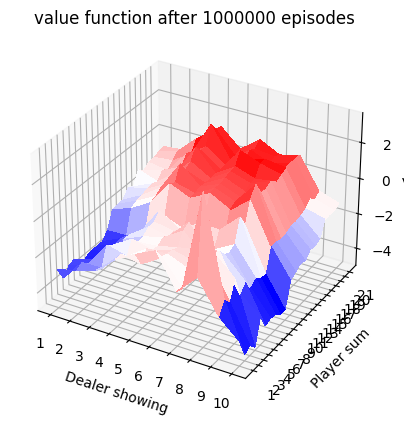

In [29]:
sarsa_agent = Sarsa(Environment(), Lambda = 1)
sarsa_agent.train(1000000)

fig = plt.figure()
ax = fig.add_subplot(111,projection ='3d')
sarsa_agent.plot_frame(ax)
plt.title('value function after %d episodes' % sarsa_agent.episodes)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('V(s)')
ax.set_xticks(range(1,sarsa_agent.env.dealer_value_count+1))
ax.set_yticks(range(1,sarsa_agent.env.player_value_count+1))
plt.show()

In [38]:
def plot_error_vs_episode(sqrt_error, lambdas, train_steps=1000000, eval_steps=1000,
                          title='SQRT error VS episode number', save_as_file=False):
    """
    Given the sqrt error between sarsa(lambda) for multiple lambdas and
    an already trained MC control model this function plots a
    graph: sqrt error VS episode number.

    Args:
        sqrt_error (tensor): Multi dimension tensor.
        lambdas (tensor): 1D tensor.
        train_steps (int): The total steps used to train the models.
        eval_steps (int): Train_steps/eval_steps is the number of time the
                          errors were calculated while training.
        save_as_file (boolean).
    """
    # avoid zero division
    assert eval_steps != 0
    x_range = np.arange(0, train_steps, eval_steps)

    # assert that the inputs are correct
    assert len(sqrt_error) == len(lambdas)
    for e in sqrt_error:
        assert len(list(x_range)) == len(e)

    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    for i in range(len(sqrt_error)-1, -1, -1):
        ax.plot(x_range, sqrt_error[i], label='lambda %.2f' % lambdas[i])

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

def plot_error_vs_lambda(sqrt_error, lambdas, title='SQRT error vs lambda', save_as_file=False):
    """
        Given the sqrt error between sarsa(lambda) for multiple lambdas and
        an already trainedMC Control ths function plots a graph:
        sqrt error VS lambda.

        Args:
            sqrt_error (tensor): multiD tensor.
            lambdas (tensor): 1D tensor.
            title (string): Plot title.
            save_as_file (boolean).

        The srt_error 1D length must be equal to the lambdas length.
    """

    # assert input is correct
    assert len(sqrt_error) == len(lambdas)

    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    # Y are the last values found at sqrt_error
    y = [s[-1] for s in sqrt_error]
    ax.plot(lambdas, y)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

In [39]:
lambdas = [e/10.0 for e in range(0, 11, 1)]

In [40]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1 - q2))

TRAIN_STEPS = 10000
EVAL_STEPS = 1000
errors = []
for i, l in enumerate(lambdas):
    print('Training Sarsa(%.1f)' % l)
    errors.append([])
    sarsa_agent = Sarsa(environment, Lambda=l)
    for j in range(TRAIN_STEPS//EVAL_STEPS):
        sarsa_agent.train(EVAL_STEPS)
        errors[i].append(mean_sqr(mc_agent.Q, sarsa_agent.Q))

Training Sarsa(0.0)
Training Sarsa(0.1)
Training Sarsa(0.2)
Training Sarsa(0.3)
Training Sarsa(0.4)
Training Sarsa(0.5)
Training Sarsa(0.6)
Training Sarsa(0.7)
Training Sarsa(0.8)
Training Sarsa(0.9)
Training Sarsa(1.0)


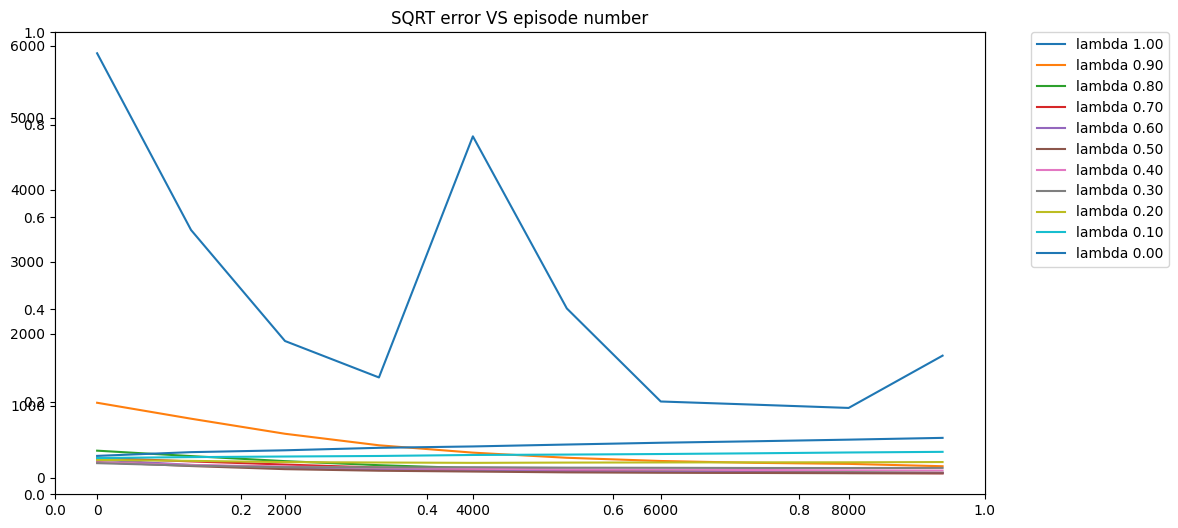

In [41]:
plot_error_vs_episode(errors, lambdas, train_steps=TRAIN_STEPS, eval_steps=EVAL_STEPS)

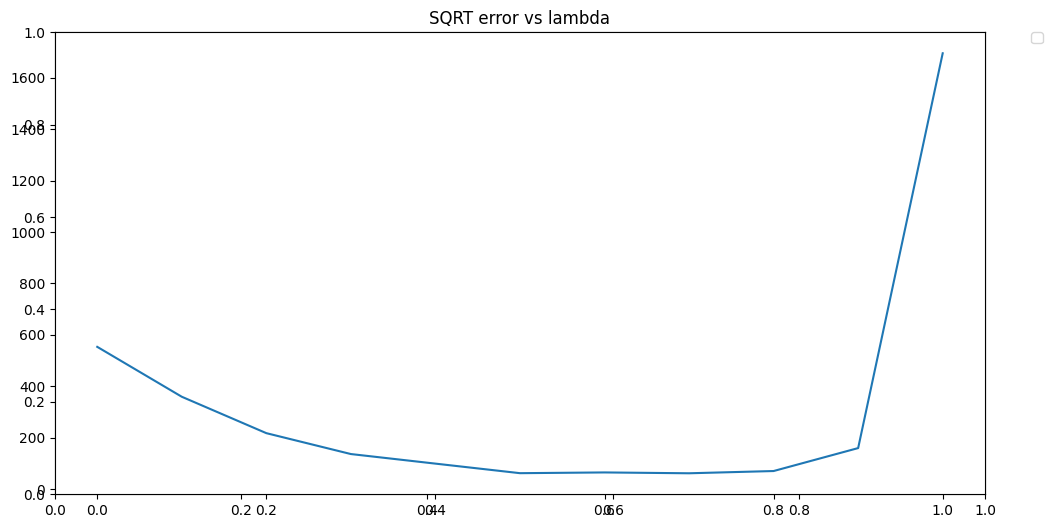

In [42]:
plot_error_vs_lambda(errors, lambdas)

In [45]:
#EASY21-Linear Function Approximation
class SarsaLFA:
  def __init__(self, environment, Lambda, gamma=1, No=200):
    self.env = environment
    self.gamma = gamma
    self.Lambda = Lambda
    self.params = 36
    self.theta = np.random.randn(self.params) * 0.1
    self.V = np.zeros((self.env.dealer_value_count+1, self.env.player_value_count+1))

    # features
    self.dealer_features = [[1, 4], [4, 7], [7, 10]]
    self.player_features = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]

    self.iterations = 0
    self.wins = 0

  def get_alpha(self, state, a):
    return 0.01

  def get_e(self, state):
    return 0.05

  def try_all_actions(self, s):
    return [np.dot(self.phi(s, Action.stick), self.theta), np.dot(self.phi(s, Action.hit), self.theta)]

  def get_max_action(self, s):
    return np.max(self.try_all_actions(s))

  def get_value_function(self):
    for i in range(1, self.env.dealer_value_count + 1):
        for j in range(1, self.env.player_value_count + 1):
            s = State(i, j)
            self.V[i][j] = self.get_max_action(s)
    return self.V

  def get_q(self, s, a):
        return np.dot(self.phi(s, a), self.theta)

  def get_all_q(self):
      q = np.zeros((self.env.dealer_value_count + 1,
                        self.env.player_value_count + 1,
                        self.env.action_count))

      for i in range(1, self.env.dealer_value_count + 1):
          for j in range(1, self.env.player_value_count + 1):
              for a in [Action.hit, Action.stick]:
                  s = State(i, j)
                  q[i, j, Action.as_int(a)] = self.get_q(s, a)

      return q

  def phi(self, s, a):
    d_sum = s.dealer
    p_sum = s.player

    features = np.zeros((3, 6, 2), dtype=np.int)

    d_features = np.array([x[0] <= d_sum <= x[1] for x in self.dealer_features])
    p_features = np.array([x[0] <= p_sum <= x[1] for x in self.player_features])

    for i in np.where(d_features):
        for j in np.where(p_features):
            features[i, j, Action.as_int(a)] = 1

    return features.flatten()

  def choose_random_action(self):
    return Action.hit if random.random() <= 0.5 else Action.stick

  def choose_best_action(self, s):
    return Action.hit if np.argmax(self.try_all_actions(s)) == 1 else Action.stick

  def policy(self, state):
    e = self.get_e(state)
    if random.random()<=e:
      a = self.choose_random_action()
    else:
      a = self.choose_best_action(state)

    return a

  def train(self, steps):
    self.episodes = steps
    for e in range(steps):

      self.E = np.zeros(self.params)
      s = self.env.gen_start_state()
      a = self.policy(s)
      next_a = a

      while not s.is_terminal:

        next_s, r = self.env.step(copy.copy(s), a)
        phi = self.phi(s, a)
        q = self.get_q(s, a)

        if not next_s.is_terminal:
            next_a = self.policy(next_s)
            q_next = self.get_q(next_s, next_a)
            delta = r + q_next - q
        else:
            delta = r - q

        self.E += phi
        alpha = self.get_alpha(s, a)
        self.theta += alpha * delta * self.E
        self.E *= (self.gamma * self.Lambda)

        s = next_s
        a = next_a

      if e % 100000 == 0 and e != 0:
          print("Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100))

      self.iterations += 1
      if r == 1:
          self.wins += 1


  def plot_frame(self, ax):
    V = self.get_value_function()
    def get_stat_val(x,y):
      return V[x,y]
    X = np.arange(1,self.env.dealer_value_count+1)
    Y = np.arange(1,self.env.player_value_count+1)
    X,Y = np.meshgrid(X,Y)
    Z = get_stat_val(X,Y)

    surf = ax.plot_surface(X,Y,Z,cmap=cm.bwr,antialiased=False)
    return surf

<ipython-input-45-e9a8cc677b85>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.zeros((3, 6, 2), dtype=np.int)


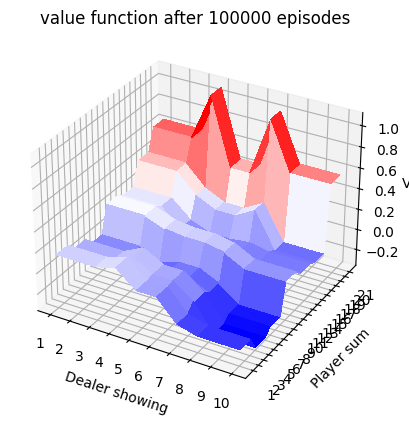

In [46]:
lfa_agent = SarsaLFA(Environment(), Lambda = 1)
lfa_agent.train(100000)

fig = plt.figure()
ax = fig.add_subplot(111,projection ='3d')
lfa_agent.plot_frame(ax)
plt.title('value function after %d episodes' % lfa_agent.episodes)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('V(s)')
ax.set_xticks(range(1,lfa_agent.env.dealer_value_count+1))
ax.set_yticks(range(1,lfa_agent.env.player_value_count+1))
plt.show()

In [47]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1 - q2))

EVAL_STEPS = 1000
TRAIN_STEPS = 100000
errors = []
for i, l in enumerate(lambdas):
    print('Training Sarsa(%f)' % l)
    errors.append([])
    sarsa_agent = SarsaLFA(environment, Lambda=l)
    for j in range(TRAIN_STEPS//EVAL_STEPS):
        sarsa_agent.train(TRAIN_STEPS//EVAL_STEPS)
        errors[i].append(mean_sqr(mc_agent.Q, sarsa_agent.get_all_q()))

Training Sarsa(0.000000)


<ipython-input-45-e9a8cc677b85>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.zeros((3, 6, 2), dtype=np.int)


Training Sarsa(0.100000)
Training Sarsa(0.200000)
Training Sarsa(0.300000)
Training Sarsa(0.400000)
Training Sarsa(0.500000)
Training Sarsa(0.600000)
Training Sarsa(0.700000)
Training Sarsa(0.800000)
Training Sarsa(0.900000)
Training Sarsa(1.000000)


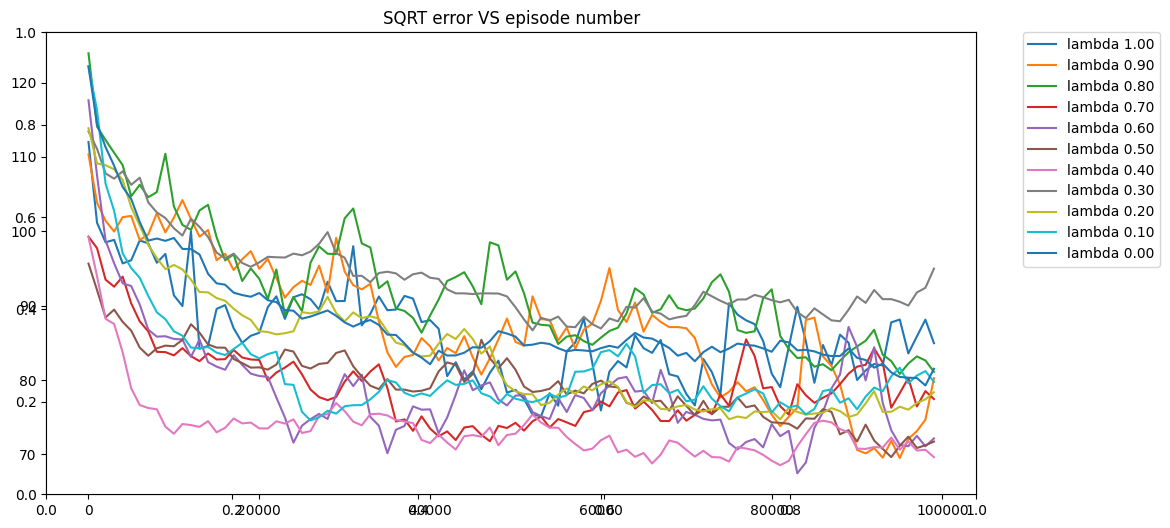

In [48]:
plot_error_vs_episode(errors, lambdas, train_steps=TRAIN_STEPS, eval_steps=EVAL_STEPS)

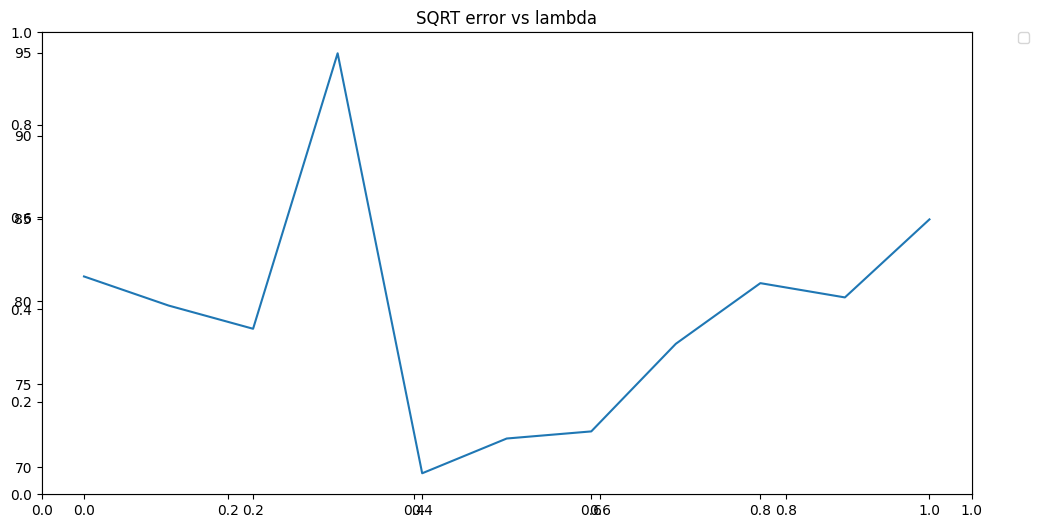

In [49]:
plot_error_vs_lambda(errors, lambdas)